In [1]:
import os, sys
sys.path.append(os.path.expanduser('~/Research/lab/KAMemory/src'))
import utils
import torch
from models import Autoencoder, MTL, logger
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from torch import nn

In [2]:

""" settings """

# architecture sizes
dim_ei = 50
dim_ca3 = 50
dim_ca1 = 50
dim_eo = dim_ei

# data settings
nb_samples = 200
num_reconstructions = 1

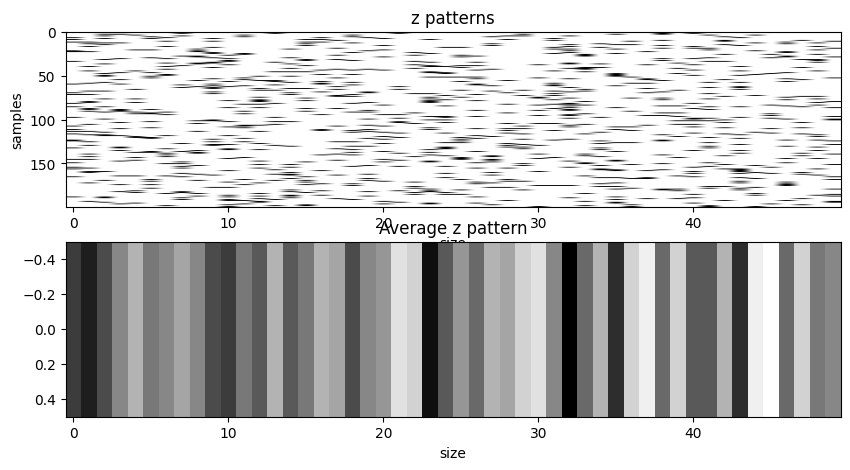

In [3]:
""" Data generation """

# --- DISTRIBUTION 1 ---
heads = 3
variance = 0.05
higher_heads = heads
higher_variance = 0.075

# make samples
distrib_1 = utils.stimulus_generator(N=nb_samples, size=dim_ei,
                             heads=heads, variance=variance,
                             higher_heads=higher_heads,
                             higher_variance=higher_variance,
                             plot=False)
test_distrib_1 = utils.stimulus_generator(N=nb_samples, size=dim_ei,
                             heads=heads, variance=variance,
                             higher_heads=higher_heads,
                             higher_variance=higher_variance,
                             plot=False)

# --- DISTRIBUTION 2 ---
heads = 2
variance = 0.05
higher_heads = heads 
higher_variance = 0.075

# make samples
distrib_2 = utils.stimulus_generator(N=nb_samples, size=dim_ei,
                             heads=heads, variance=variance,
                             higher_heads=higher_heads,
                             higher_variance=higher_variance,
                             plot=False)
test_distrib_2 = utils.stimulus_generator(N=nb_samples, size=dim_ei,
                             heads=heads, variance=variance,
                             higher_heads=higher_heads,
                             higher_variance=higher_variance,
                             plot=False)

# --- DISTRIBUTION 3 ---
distrib_13 = utils.sparse_stimulus_generator(N=nb_samples,
                                             size=dim_ei,
                                             K = 5,
                                             plot=True)

# ----------------------
# make one data dataset
if bool(0):
    training_samples = np.concatenate((distrib_2, distrib_1), axis=0)
    test_samples = np.concatenate((test_distrib_2, test_distrib_1), axis=0)

    # shuffle
    training_samples = training_samples[torch.randperm(training_samples.shape[0])]
    test_samples = test_samples[torch.randperm(test_samples.shape[0])]
    logger.debug("using both distributions")

else:
    training_samples = distrib_2
    test_samples = test_distrib_2

# dataset for btsp
num_btsp_samples = 1
num_reconstructions = 1
training_sample_btsp = training_samples[np.random.choice(
                        range(training_samples.shape[0]),
                        num_btsp_samples, replace=False)]

In [ ]:
# --- sparse data

N = nb_samples
K = 5
training_samples = utils.sparse_stimulus_generator(N=N, K=K, size=dim_ei,
                                                   plot=False)
test_samples = utils.sparse_stimulus_generator(N=N, K=K, size=dim_ei,
                                               plot=False)

logger("<<< Data generated >>>")

In [ ]:
# dataset for btsp
num_btsp_samples = 1
num_reconstructions = 1
training_sample_btsp = training_samples[np.random.choice(
                        range(training_samples.shape[0]),
                        num_btsp_samples, replace=False)]

In [ ]:

""" AUTOENCODER training """

autoencoder = Autoencoder(input_dim=dim_ei,
                          encoding_dim=dim_ca1)
logger(f"%Autoencoder: {autoencoder}")

# train autoencoder
epochs = 100
loss_ae, autoencoder = utils.train_autoencoder(
                training_data=training_samples,
                test_data=test_samples,
                model=autoencoder,
                epochs=int(epochs),
                batch_size=5, learning_rate=1e-3)
logger(f"<<< Autoencoder trained [loss={loss_ae:.4f}] >>>")

# reconstruct data
out_ae, latent_ae = utils.reconstruct_data(data=training_sample_btsp,
                                num=num_btsp_samples,
                                model=autoencoder,
                                show=False, 
                                plot=False)

-------------------------
CLOSE-UP ON MTL MODEL

In [ ]:
# --- MODEL DEFINITION

Kis = 10

# imported weights
w_ei_ca1, w_ca1_eo = autoencoder.get_weights()


# input stimulus
x_ei = torch.tensor(training_sample_btsp[0].reshape(-1, 1).astype(np.float32))

out_ae = autoencoder(x_ei.reshape(1, -1)).detach().numpy().reshape(1, -1)

In [ ]:

# random weights
w_ei_ca3 = nn.Parameter(torch.randn(dim_ca3, dim_ei) / dim_ca3**0.7)
w_ca3_ca1 = nn.Parameter(torch.zeros(dim_ca1, dim_ca3))

# --- MODEL TRAINING

# Forward pass through EI to CA3 to CA1
x_ca3 = w_ei_ca3 @ x_ei
IS = w_ei_ca1 @ x_ei

# --- modify the instructive signal
is_ = IS.detach().numpy().flatten().copy()
clipped = np.where(np.abs(is_) > 0.1,
             is_, 0).reshape(-1, 1).astype(np.float32)
             # 1, 0).reshape(-1, 1).astype(np.float32)
IS = torch.tensor(clipped)

# ----- rule 1
# betas = torch.zeros_like(IS)
# betas[torch.topk(IS.flatten(), Kis).indices] = 1.

# # betas = betas.reshape(IS.shape)
# tiled_ca3 = x_ca3.flatten().repeat(dim_ca1, 1)
# w_ca3_ca1 = nn.Parameter((1 - betas) * w_ca3_ca1 + betas * tiled_ca3)

# ----- rule 2
w_ca3_ca1_prime  = nn.Parameter(IS @ x_ca3.T)
w_ca3_ca1 = nn.Parameter(w_ca3_ca1_prime)

# -- TEST
x_eo = w_ca1_eo @ (w_ca3_ca1 @ (w_ei_ca3 @ x_ei))

out = x_eo.detach().numpy().reshape(1, -1)


# --- PLOT
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 5),
                               sharex=True)

#
ax1.imshow(x_ei.numpy().reshape(1, -1), aspect="auto",
           cmap="Greys", vmin=0, vmax=1)
ax1.set_ylabel("Input data")
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(out_ae, aspect="auto", cmap="Greys",
           vmin=0, vmax=1)
ax2.set_ylabel("Autoencoder")
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(out, aspect="auto", cmap="Greys",
           vmin=0, vmax=1)
ax3.set_ylabel("MTL")
ax3.set_xticks([])
ax3.set_yticks([])

plt.show()

In [ ]:

plt.hist(is_.flatten(), bins=10, alpha=0.4)
plt.hist(clipped.flatten(), bins=10, alpha=0.4)
plt.show()

In [ ]:
plt.hist(IS.flatten(), label="$IS$", alpha=0.4, density=True)
plt.hist(x_ca3.detach().flatten(), label="$x_{CA3}$", alpha=0.4, density=True)
plt.legend()
plt.title("Contributions for $W_{CA3, CA1}$")
plt.show()

In [ ]:
# x_ca3
plt.hist(x_ca3.detach().flatten(), bins=10, alpha=0.4)
plt.show()

In [ ]:
plt.subplot(221)
# plt.axis("off")
plt.imshow(w_ei_ca1.detach().numpy(), aspect="auto", cmap="RdYlGn",
           vmin=-1., vmax=1.)
plt.title("$W_{EI, CA1}$")

plt.subplot(222)
plt.imshow(x_ca3.detach().numpy().T, aspect="auto",
           cmap="RdYlGn", vmin=-1., vmax=1.)
plt.yticks([])
plt.title("$x_{CA3}$")

plt.subplot(223)
plt.imshow(IS, aspect="auto",
           cmap="RdYlGn", vmin=-1., vmax=1.)
plt.xticks([])
plt.title("$IS$")

plt.subplot(224)
# plt.imshow(weica1, aspect="auto", cmap="RdYlGn",
#            vmin=-1., vmax=1.)
plt.imshow(w_ca3_ca1.detach().numpy(), aspect="auto", cmap="RdYlGn",
           vmin=-1., vmax=1.)
plt.title("$W_{CA3, CA1}$")
# plt.colorbar()
plt.show()

In [ ]:
x_ca1 = w_ca3_ca1 @ x_ca3
plt.subplot(211)
plt.imshow(x_ca1.detach().numpy().T, aspect="auto",
              cmap="RdYlGn", vmin=-1., vmax=1.)
plt.title("$x_{CA1}$")

plt.subplot(212)
plt.imshow(IS.detach().numpy().T, aspect="auto",
              cmap="RdYlGn", vmin=-1., vmax=1.)
plt.title("$IS$")
plt.yticks([])
plt.xticks([])
plt.show()

In [ ]:
# --- eigen-decomposition

# EI -> CA1
evals_ei_ca1, evect_ei_ca1  = np.linalg.eig(w_ei_ca1.detach().numpy())

# CA3 -> CA1
weica1 = w_ca3_ca1.detach().numpy() @ w_ei_ca3.detach().numpy()
# evals_ca3_ca1, evect_ca3_ca1  = np.linalg.eig(w_ca3_ca1.detach().numpy())
evals_ca3_ca1, evect_ca3_ca1  = np.linalg.eig(weica1)

# plot
plt.scatter(evals_ei_ca1.real, evals_ei_ca1.imag, label="$EI$->", s=2)
plt.scatter(evals_ca3_ca1.real, evals_ca3_ca1.imag, label="$CA3$->", s=2)
plt.legend()
plt.xlabel("$Re$")
plt.ylabel("$Im$")
plt.show()

In [ ]:

""" MTL declaration """

# get weights from the autoencoder
W_ei_ca1, W_ca1_eo = autoencoder.get_weights()
# W_ei_ca1 = torch.randn(dim_ca1, dim_ei)
# W_ca1_eo = torch.randn(dim_eo, dim_ca1)

# make model
model = MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            dim_ca3=dim_ca3,
            lr=1.)
model_rnd = MTL(W_ei_ca1=torch.randn(dim_ca1, dim_ei),
            W_ca1_eo=torch.randn(dim_eo, dim_ca1),
            dim_ca3=dim_ca3,
            lr=1.)

logger(f"%MTL: {model}")

In [ ]:

""" MODEL training """

epochs = 1
for _ in range(epochs):
    loss_mtl, model = utils.testing(data=training_sample_btsp,
                                    model=model,
                                    column=True)
    loss_mtl_rnd, model_rnd = utils.testing(data=training_sample_btsp,
                                            model=model_rnd,
                                            column=True)
    logger(f"<<< MTL trained [{loss_mtl:.3f}] >>>")
    logger(f"<<< MTL_random trained [{loss_mtl_rnd:.3f}] >>>")

# reconstruct data
model.pause_lr()
out_mtl, latent_mtl = utils.reconstruct_data(
                                 data=training_sample_btsp,
                                 num=num_btsp_samples,
                                 model=model,
                                 column=True,
                                 plot=False)

model_rnd.pause_lr()
out_mtl_rnd, latent_mtl_rnd = utils.reconstruct_data(
                                 data=training_sample_btsp,
                                 num=num_btsp_samples,
                                 model=model_rnd,
                                 column=True,
                                 plot=False)

In [ ]:
sample = torch.tensor(training_sample_btsp[0].reshape(-1, 1),
                      requires_grad=False).float()
print(sample.shape)
out = model(sample)
# print(out)

-------------------------
TESTING & VISUALIZATION

In [ ]:
idx_sample = 0

data = training_sample_btsp[idx_sample].reshape(1, -1)

if not isinstance(training_sample_btsp,
                  DataLoader):
    # Convert numpy array to torch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32)

    # Create a dataset and data loader
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

else:
    dataloader = data

column = True


# Set the model to evaluation mode
model.eval()

loss = 0.

with torch.no_grad():

    for batch in dataloader:

        inputs = batch[0] if not column else batch[0].reshape(-1, 1)

        # Forward pass
        outputs = model(inputs)

        # evaluate the output

if idx_sample == 0:
    outs1 = [model._ca3, model._ca1]

    fig1, (ax11, ax12) = plt.subplots(2, 1, figsize=(20, 10))
    ax11.imshow(outs1[0].reshape(1, -1), aspect="auto", cmap="Greys_r")
    ax11.set_title("pattern 1 | CA3")

    ax12.imshow(outs1[1].reshape(1, -1), aspect="auto", cmap="Greys_r")
    ax12.set_title("pattern 1 | CA1")

elif idx_sample == 1:

    outs2 = [model._ca3, model._ca1]

    fig1, (ax21, ax22) = plt.subplots(2, 1, figsize=(20, 10))
    ax21.imshow(outs2[0].reshape(1, -1), aspect="auto", cmap="Greys_r")
    ax21.set_title("pattern 2 | CA3")

    ax22.imshow(outs2[1].reshape(1, -1), aspect="auto", cmap="Greys_r")
    ax22.set_title("pattern 2 | CA1")

plt.show()

In [ ]:
out2 = model._ca3
out2

fig2, ax2 = plt.subplots()
ax2.imshow(out2.reshape(1, -1), aspect="auto", cmap="Greys_r")
ax2.set_title("pattern 2")

In [ ]:

plt.show()

In [ ]:

np.dot(outs1[0], outs2[1])

In [ ]:




""" plotting """

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 5), sharex=True)

# is_squash = False
# utils.plot_squashed_data(
#     # data=training_samples[:num_reconstructions].reshape(num_reconstructions, -1),
#     data=training_sample_btsp,
#                          ax=ax1,
#                          title="Original", squash=is_squash)
# utils.plot_squashed_data(data=out_ae, ax=ax2,
#                          title="Autoencoder", squash=is_squash)
# utils.plot_squashed_data(data=out_mtl, ax=ax3,
#                          title="MTL", squash=bool(1))
# utils.plot_squashed_data(data=out_mtl_rnd, ax=ax4,
#                          title="MTL (random)", squash=is_squash)

# fig.suptitle("Data reconstruction | all data vs first input")
# plt.show()


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

ax1.imshow(latent_ae[:5], cmap='gray_r', aspect='auto')
ax1.set_ylabel("Autoencoder")
print(f"\n>>> latent_ae (last ECin input): {np.around(latent_ae[-1], 2)}")

ax2.imshow(latent_mtl[:5], cmap='gray_r', aspect='auto')
ax2.set_ylabel("MTL")
print(f"\n>>> latent_mtl (last ECin input): {np.around(latent_mtl[-1], 2)}")

ax3.imshow(latent_mtl_rnd[:5], cmap='gray_r', aspect='auto')
ax3.set_ylabel("MTL (random)")
print(f"\n>>> latent_mtl_rnd (last ECin input): {np.around(latent_mtl_rnd[-1], 2)}")

fig.suptitle("Latent space [CA1]")
plt.show()